# Preparation

In [135]:
import numpy as np, pandas as pd
import re, string

import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import joblib

import sklearn
from sklearn.metrics import *

In [26]:
toxic_data_dir = '../../jigsaw-toxic-comment-classification-challenge'

train_df = pd.read_csv(f'{toxic_data_dir}/train.csv')
test_df = pd.read_csv(f'{toxic_data_dir}/test.csv')
test_label_df = pd.read_csv(f'{toxic_data_dir}/test_labels.csv')
submission_df = pd.read_csv(f'{toxic_data_dir}/sample_submission.csv')


# Data Exploration

### Take a quick look of the dataset

Each row contains a comment and 6 labels of the comment.

In [16]:
# train_df[train_df['toxic'] != 0].head()
train_df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

### Data completeness check

The data is 100% complete.

In [48]:

print('+++Train Data+++')

count_row, _ = train_df.shape
for col in train_df.columns[1:]:

    count_nan = train_df[col].isnull().sum()
    perc_compl = 1 - count_nan / count_row

    print('{}: {:.3%}'.format(col, perc_compl))


print('+++Test Data+++')

count_row, _ = test_df.shape
for col in test_df.columns[1:]:

    count_nan = test_df[col].isnull().sum()
    perc_compl = 1 - count_nan / count_row

    print('{}: {:.3%}'.format(col, perc_compl))

+++Train Data+++
comment_text: 100.000%
toxic: 100.000%
severe_toxic: 100.000%
obscene: 100.000%
threat: 100.000%
insult: 100.000%
identity_hate: 100.000%
toxicity: 100.000%
+++Test Data+++
comment_text: 100.000%


### The length of the text
The length of the comments are highly skewed.

In [20]:
comment_length = train_df['comment_text'].str.len()
comment_length.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

<AxesSubplot:>

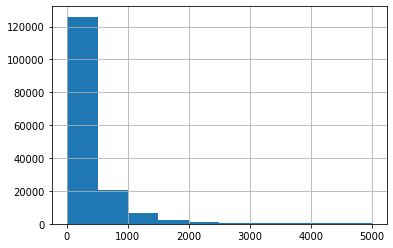

In [24]:
comment_length.hist()

### Comment class overview

Out of 159571 cases from train data, Most of the comments are clean. 16225 comments has at least 1 toxicity class. Toxicity is not evenly spread out across classes. Some comments have more than 1 class.

In [27]:
toxicity_cols = train_df.columns[2:]


The labels are either 0 or 1 representing 2 status. There's no unknown tag, the data is pretty clean.

In [118]:
for col in toxicity_cols:
    print(train_df[col].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [30]:
train_df['toxicity'] = 0

train_df.loc[(train_df[toxicity_cols] == 1).any(axis=1), 'toxicity'] = 1

train_df['toxicity'].sum()

16225

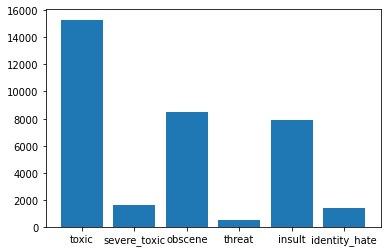

In [31]:
x = np.arange(6)

cnt = [train_df[col].sum() for col in toxicity_cols]


fig, ax = plt.subplots()
plt.bar(x, cnt)
plt.xticks(x, toxicity_cols)
plt.show()

# Modelling Strategy - NB-SVM

The strategy of this trial is to use naive bayes features and SVM (logistic regression with liblinear optimization) for topic classification. The idea is borrowed from [a notebook](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline) and [a paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf), and adjustment has been made for the bell technical assessment.

## Feature engineering

Create tf-idf sparse matrix

In [44]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub(r' \1 ', s).split() # split by punctuations


In [49]:
n = train_df.shape[0]


vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                      min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1 )

train_term_doc = vec.fit_transform(train_df['comment_text'])
test_term_doc = vec.transform(test_df['comment_text'])


Implement naive bayesian feature and train the models

In [96]:
def pr(y, y_i):
    p = train_term_doc[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)


In [105]:
def train(toxic_col):
    print(f'fitting {toxic_col} ...')
    y = train_df[toxic_col].values
    r = np.log(pr(y, 1) / pr(y, 0)) # log count ratio
    
    lr = LogisticRegression(C=4, dual=True, solver='liblinear')
    x_nb = train_term_doc.multiply(r)
    model = lr.fit(x_nb, y)
    
    return model, r

In [106]:
models = []

for i, j in enumerate(toxicity_cols):
    m, r = train(j)
    models.append((m, r))


fitting toxic ...
fitting severe_toxic ...


C:\Users\ashley\anaconda3\envs\bell_test\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


fitting obscene ...
fitting threat ...
fitting insult ...
fitting identity_hate ...


# Evaluation

In [110]:
preds = np.zeros((len(test_df), len(toxicity_cols)))


for i, svm in enumerate(models):
    model, weight = svm
    preds[:,i] = model.predict_proba(test_term_doc.multiply(weight))[:,1]


In [123]:

test_label_df[[f'{col}_pred' for col in toxicity_cols]] = preds


In [129]:
# drop -1 from df as the tag is not known

test_label_df[test_label_df==-1] = np.nan

test_label_df = test_label_df.dropna()

In [131]:
test_label_df.head()

id  toxic  severe_toxic  obscene  threat  insult  \
5   0001ea8717f6de06    0.0           0.0      0.0     0.0     0.0   
7   000247e83dcc1211    0.0           0.0      0.0     0.0     0.0   
11  0002f87b16116a7f    0.0           0.0      0.0     0.0     0.0   
13  0003e1cccfd5a40a    0.0           0.0      0.0     0.0     0.0   
14  00059ace3e3e9a53    0.0           0.0      0.0     0.0     0.0   

    identity_hate  toxic_pred  severe_toxic_pred  obscene_pred  threat_pred  \
5             0.0    0.004428           0.000280      0.001965     0.000373   
7             0.0    0.187793           0.000365      0.003324     0.000132   
11            0.0    0.148282           0.000203      0.008982     0.000154   
13            0.0    0.003639           0.000138      0.001658     0.000081   
14            0.0    0.002010           0.000223      0.001959     0.000078   

    insult_pred  identity_hate_pred  
5      0.003182            0.000364  
7      0.007759            0.000342  
11     0.011276            0.000873  
13     0.001007            0.000181  
14     0.001418            0.000207

## ROC AUC

The ROC plot and AUC looks good. The models take effect on classifying toxic comments.

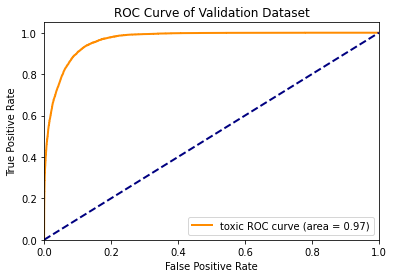

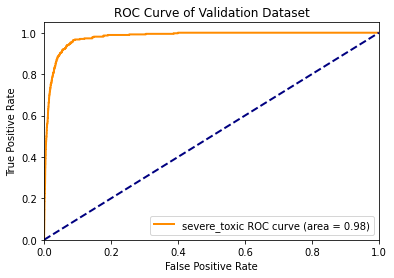

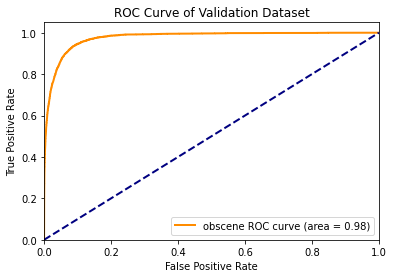

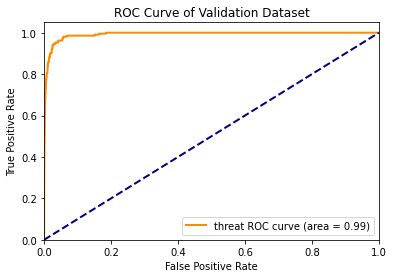

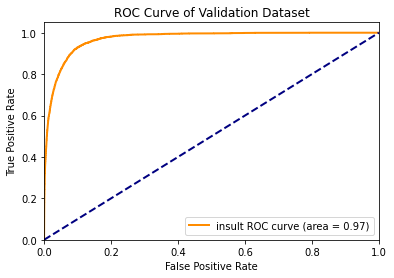

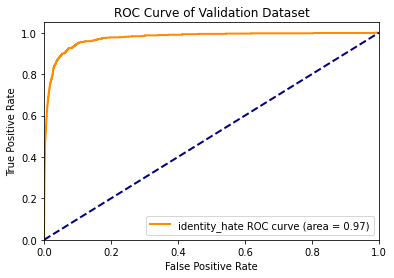

In [137]:
for col in toxicity_cols:
    fpr, tpr, _ = roc_curve(test_label_df[col], test_label_df[f'{col}_pred'])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{col} ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of Validation Dataset')
    plt.legend(loc="lower right")
    plt.show()

## Log loss

The log loss can be used to compare performance across algorithms

In [140]:
for col in toxicity_cols:
    log_loss = sklearn.metrics.log_loss(test_label_df[col], test_label_df[f'{col}_pred'])
    print(f'{col}: ', log_loss)

toxic:  0.18186842037328055
severe_toxic:  0.022690545820229103
obscene:  0.09834578841697857
threat:  0.011235048815596631
insult:  0.09483440432853894
identity_hate:  0.03163213211962077


## Bias

Bias of the toxicity classification models are 0.025 and less. The model works well that most predictions are accurate.

In [142]:
for col in toxicity_cols:
    bias = (len(test_label_df[test_label_df[f'{col}_pred']>=0.5])-len(test_label_df[test_label_df[col]==1]))/len(test_label_df)
    print(f'{col}: ', bias)

toxic:  0.024055143955734784
severe_toxic:  -9.378223764419019e-05
obscene:  -0.0038763324892931946
threat:  -0.0014379943105442496
insult:  -0.014848854293663448
identity_hate:  -0.006283409922160743


## Precision & Recall

The precision and recall curve shows the trade off of choice of probability threshold. The graphs below shows that most of the six models have a balanec at threshold of 0.5.

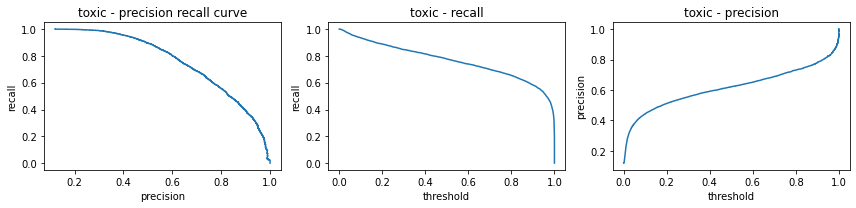

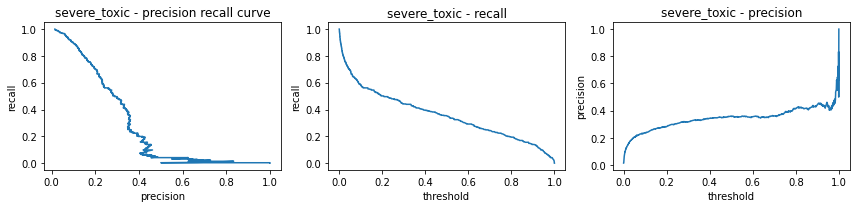

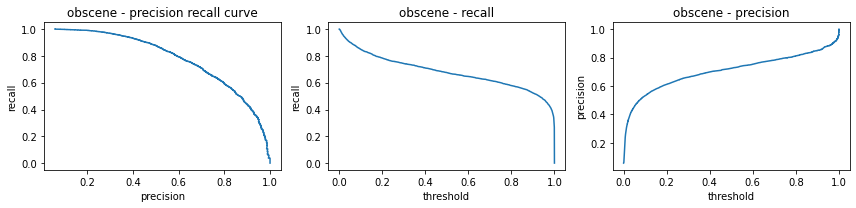

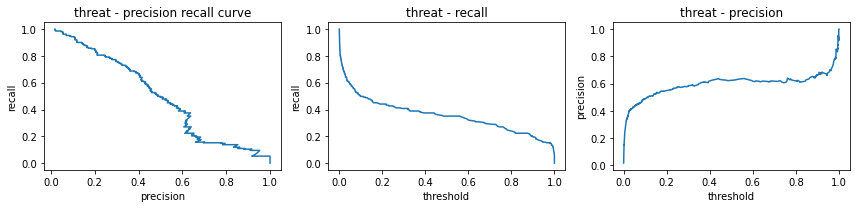

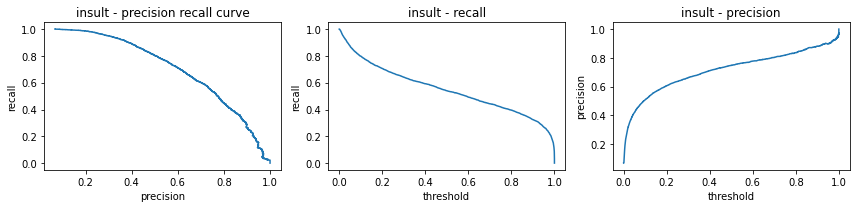

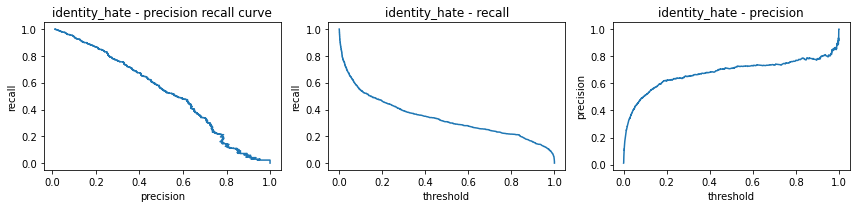

In [146]:
for col in toxicity_cols:
    precision, recall, thresholds = precision_recall_curve(test_label_df[col], test_label_df[f'{col}_pred'])
    thresholds = np.insert(thresholds, 0, 0)
    
    plt.figure(figsize= (12,3))
    plt.subplot(131, title=f'{col} - precision recall curve')
    plt.plot(precision, recall)
    plt.xlabel("precision")
    plt.ylabel("recall")

    plt.subplot(132, title=f'{col} - recall')
    plt.plot(thresholds, recall)
    plt.xlabel("threshold")
    plt.ylabel("recall")

    plt.subplot(133, title=f'{col} - precision')
    plt.plot(thresholds, precision)
    plt.xlabel("threshold")
    plt.ylabel("precision")

    plt.tight_layout()

# Save to Path

In [147]:
joblib.dump(vec, '../API/model_files/nb_svm_vectorizer.pkl')
joblib.dump(models, '../API/model_files/nb_svm_models.pkl')

['../API/model_files/nb_svm_models.pkl']